## Load Library

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

## Started Base

In [3]:
data_frame_heart = pd.read_csv('../base/heart.csv')

# Seleção de Features e Targets
* Aqui, vamos dividir os dados em dois grupos: variáveis independentes (ou variáveis features) e variáveis dependentes (variáveis target). Os populares X e Y.

In [5]:
X = data_frame_heart.iloc[:, :11]
Y = data_frame_heart.iloc[:, 11]

# Pipeline

### * Preparation

In [6]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder

df = data_frame_heart

# Colunas com valores de zero que são clinicamente impossíveis
cols_to_correct = ["RestingBP", "Cholesterol"]

# Substituir 0 por NaN (Not a Number) para que possamos calcular a mediana corretamente
for col in cols_to_correct:
    df[col] = df[col].replace(0, np.nan)

# Calcular a mediana de cada coluna (ignorando os NaN) e preencher os valores faltantes
for col in cols_to_correct:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

print("Valores nulos após a correção:")
print(df[cols_to_correct].isnull().sum())
print("\nNovas estatísticas descritivas:")
print(df[cols_to_correct].describe())

Valores nulos após a correção:
RestingBP      0
Cholesterol    0
dtype: int64

Novas estatísticas descritivas:
        RestingBP  Cholesterol
count  918.000000   918.000000
mean   132.538126   243.204793
std     17.990127    53.401297
min     80.000000    85.000000
25%    120.000000   214.000000
50%    130.000000   237.000000
75%    140.000000   267.000000
max    200.000000   603.000000


### * Create Pipeline

In [6]:
# Variables define
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_features = ['Sex', 'ExerciseAngina']
nominal_features = ['ChestPainType', 'RestingECG']
ordinal_features = ['ST_Slope']

# create the steps to be executed

"""This is done by creating a list of tuples, where each tuple contains a key and
an instance to be executed."""

numeric_transformer = Pipeline(steps=[('Encoder', RobustScaler())])
binary_transformer = Pipeline(steps = [('Encoder', OrdinalEncoder())])
nominal_transformer = Pipeline(steps = [('Encoder', OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps = [('Encoder', OrdinalEncoder(categories=[['Up', 'Flat', 'Down']]))])

# Combining Everything

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('bin', binary_transformer, binary_features),
                                               ('nom', nominal_transformer, nominal_features),
                                               ('ord', ordinal_transformer, ordinal_features)])

pipe = Pipeline(steps=[('preprocessor', preprocessor), ('DT', DecisionTreeClassifier(random_state=42))])

### * Pipeline Train Test

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

# Define o dicionário de hiperparâmetros
param_grid = {
    'DT__max_depth': [3, 5, 7, 10, None],
    'DT__min_samples_split': [2, 5, 10],
    'DT__min_samples_leaf': [1, 2, 4]
}

"""
    'DT__max_depth': Profundidade máxima da árvore. 
    O GridSearch vai testar árvores com profundidade 
    3, 5, 7, 10 e sem limite (None).

    'DT__min_samples_split': Número mínimo de amostras 
    para dividir um nó. O GridSearch vai testar 2, 5 e 10.

    'DT__min_samples_leaf': Número mínimo de amostras 
    em uma folha. O GridSearch vai testar 1, 2 e 4.
"""

# Cria o GridSearchCV usando o pipeline já definido
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajuste nos dados de treino
grid_search.fit(x_train, y_train)

# Para ROC e Precision-Recall, precisamos das probabilidades
y_pred_proba = grid_search.predict_proba(x_test)[:, 1]

# Para accuracy e confusion matrix, precisamos das predições binárias
y_pred = grid_search.predict(x_test)

# Roc and Precision Recall curve

* ROC curve is a graph that ilustrates the performace of a binary classification model across all its possible classification thresholds.
* Precision-Recall curve is also a graph that shows the performance of a binary model at different thresholds, but it focuses specifically on precision and recall metrics.

### ROC

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

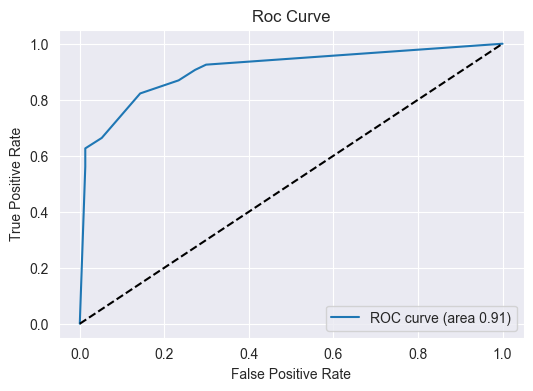

In [ ]:
"""
False Positive Rate(fpr)
True Positive Rate (tpr)
"""

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # Usar probabilidades
roc_auc = auc(fpr, tpr)

dados = {"name_model":"Decicion Tree","fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": float(roc_auc)},
import json
path = '../analysis/statiscal/roc_auc_data.json'
with open(path, "r", encoding="utf-8") as f:
    read_data = json.load(f)

read_data["dt_roc_auc"] = dados

with open(path, "w", encoding="utf-8") as f:
    json.dump(read_data, f, indent=4, ensure_ascii=False)

#Graph
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (area {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Roc Curve')
plt.show()

# Classification Report

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, output_dict=False))  # Usar predições binárias

              precision    recall  f1-score   support

           0       0.78      0.86      0.81        77
           1       0.89      0.82      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184



# Confussion Matrix

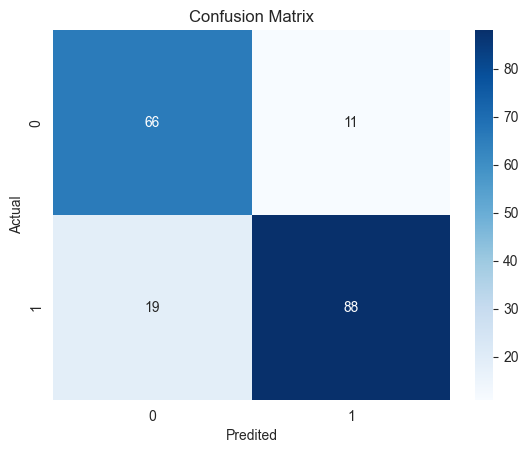

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)  # Usar predições binárias

# Graph

import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predited")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Model execution N times

### search for hiperparameters

In [12]:
from sklearn.model_selection import GridSearchCV

# Define o dicionário de hiperparâmetros
param_grid = {
    'DT__max_depth': [3, 5, 7, 10, None],
    'DT__min_samples_split': [2, 5, 10],
    'DT__min_samples_leaf': [1, 2, 4]
}

"""
    'DT__max_depth': Profundidade máxima da árvore. 
    O GridSearch vai testar árvores com profundidade 
    3, 5, 7, 10 e sem limite (None).

    'DT__min_samples_split': Número mínimo de amostras 
    para dividir um nó. O GridSearch vai testar 2, 5 e 10.

    'DT__min_samples_leaf': Número mínimo de amostras 
    em uma folha. O GridSearch vai testar 1, 2 e 4.
"""

# Cria o GridSearchCV usando o pipeline já definido
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajuste nos dados de treino
grid_search.fit(x_train, y_train)

# Veja os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score:", grid_search.best_score_)

Melhores parâmetros: {'DT__max_depth': 3, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}
Melhor score: 0.8323921349361662


### 5-fold cross-lagged evaluation using f1-score and balance_accuracy metrics

* Preparetion

In [13]:
from sklearn.model_selection import  GridSearchCV
n_repeticoes = 30

* F1-score

In [14]:
medias_f1 = []

for i in range(n_repeticoes):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    
    # GridSearchCV with multiple metrics
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(x_train, y_train)

    score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
    
    print(
        f"Execution {i + 1}/{n_repeticoes} | Average F1-score: {score:.4f}"
    )

    # Saves the average metrics of the best configuration
    medias_f1.append(score)

print(f"Final Average F1: {np.mean(medias_f1):.4f}")



Execution 1/30 | Average F1-score: 0.8643
Execution 2/30 | Average F1-score: 0.8610
Execution 3/30 | Average F1-score: 0.8692
Execution 4/30 | Average F1-score: 0.8574
Execution 5/30 | Average F1-score: 0.8385
Execution 6/30 | Average F1-score: 0.8475
Execution 7/30 | Average F1-score: 0.8594
Execution 8/30 | Average F1-score: 0.8531
Execution 9/30 | Average F1-score: 0.8545
Execution 10/30 | Average F1-score: 0.8584
Execution 11/30 | Average F1-score: 0.8632
Execution 12/30 | Average F1-score: 0.8704
Execution 13/30 | Average F1-score: 0.8574
Execution 14/30 | Average F1-score: 0.8575
Execution 15/30 | Average F1-score: 0.8707
Execution 16/30 | Average F1-score: 0.8650
Execution 17/30 | Average F1-score: 0.8327
Execution 18/30 | Average F1-score: 0.8617
Execution 19/30 | Average F1-score: 0.8519
Execution 20/30 | Average F1-score: 0.8468
Execution 21/30 | Average F1-score: 0.8548
Execution 22/30 | Average F1-score: 0.8444
Execution 23/30 | Average F1-score: 0.8420
Execution 24/30 | Av

# Displaying the tree

In [15]:

feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out(X.columns)
feature_names

array(['num__Age', 'num__RestingBP', 'num__Cholesterol', 'num__MaxHR',
       'num__Oldpeak', 'bin__Sex', 'bin__ExerciseAngina',
       'nom__ChestPainType_ASY', 'nom__ChestPainType_ATA',
       'nom__ChestPainType_NAP', 'nom__ChestPainType_TA',
       'nom__RestingECG_LVH', 'nom__RestingECG_Normal',
       'nom__RestingECG_ST', 'ord__ST_Slope'], dtype=object)

### Uma visualisação gráfica de como ficaria a Árvore de Decisão
* Infelizmente não foi possivel conseguir uma qualidade melhor, pois isso faria os NÓs ficarem amotoados

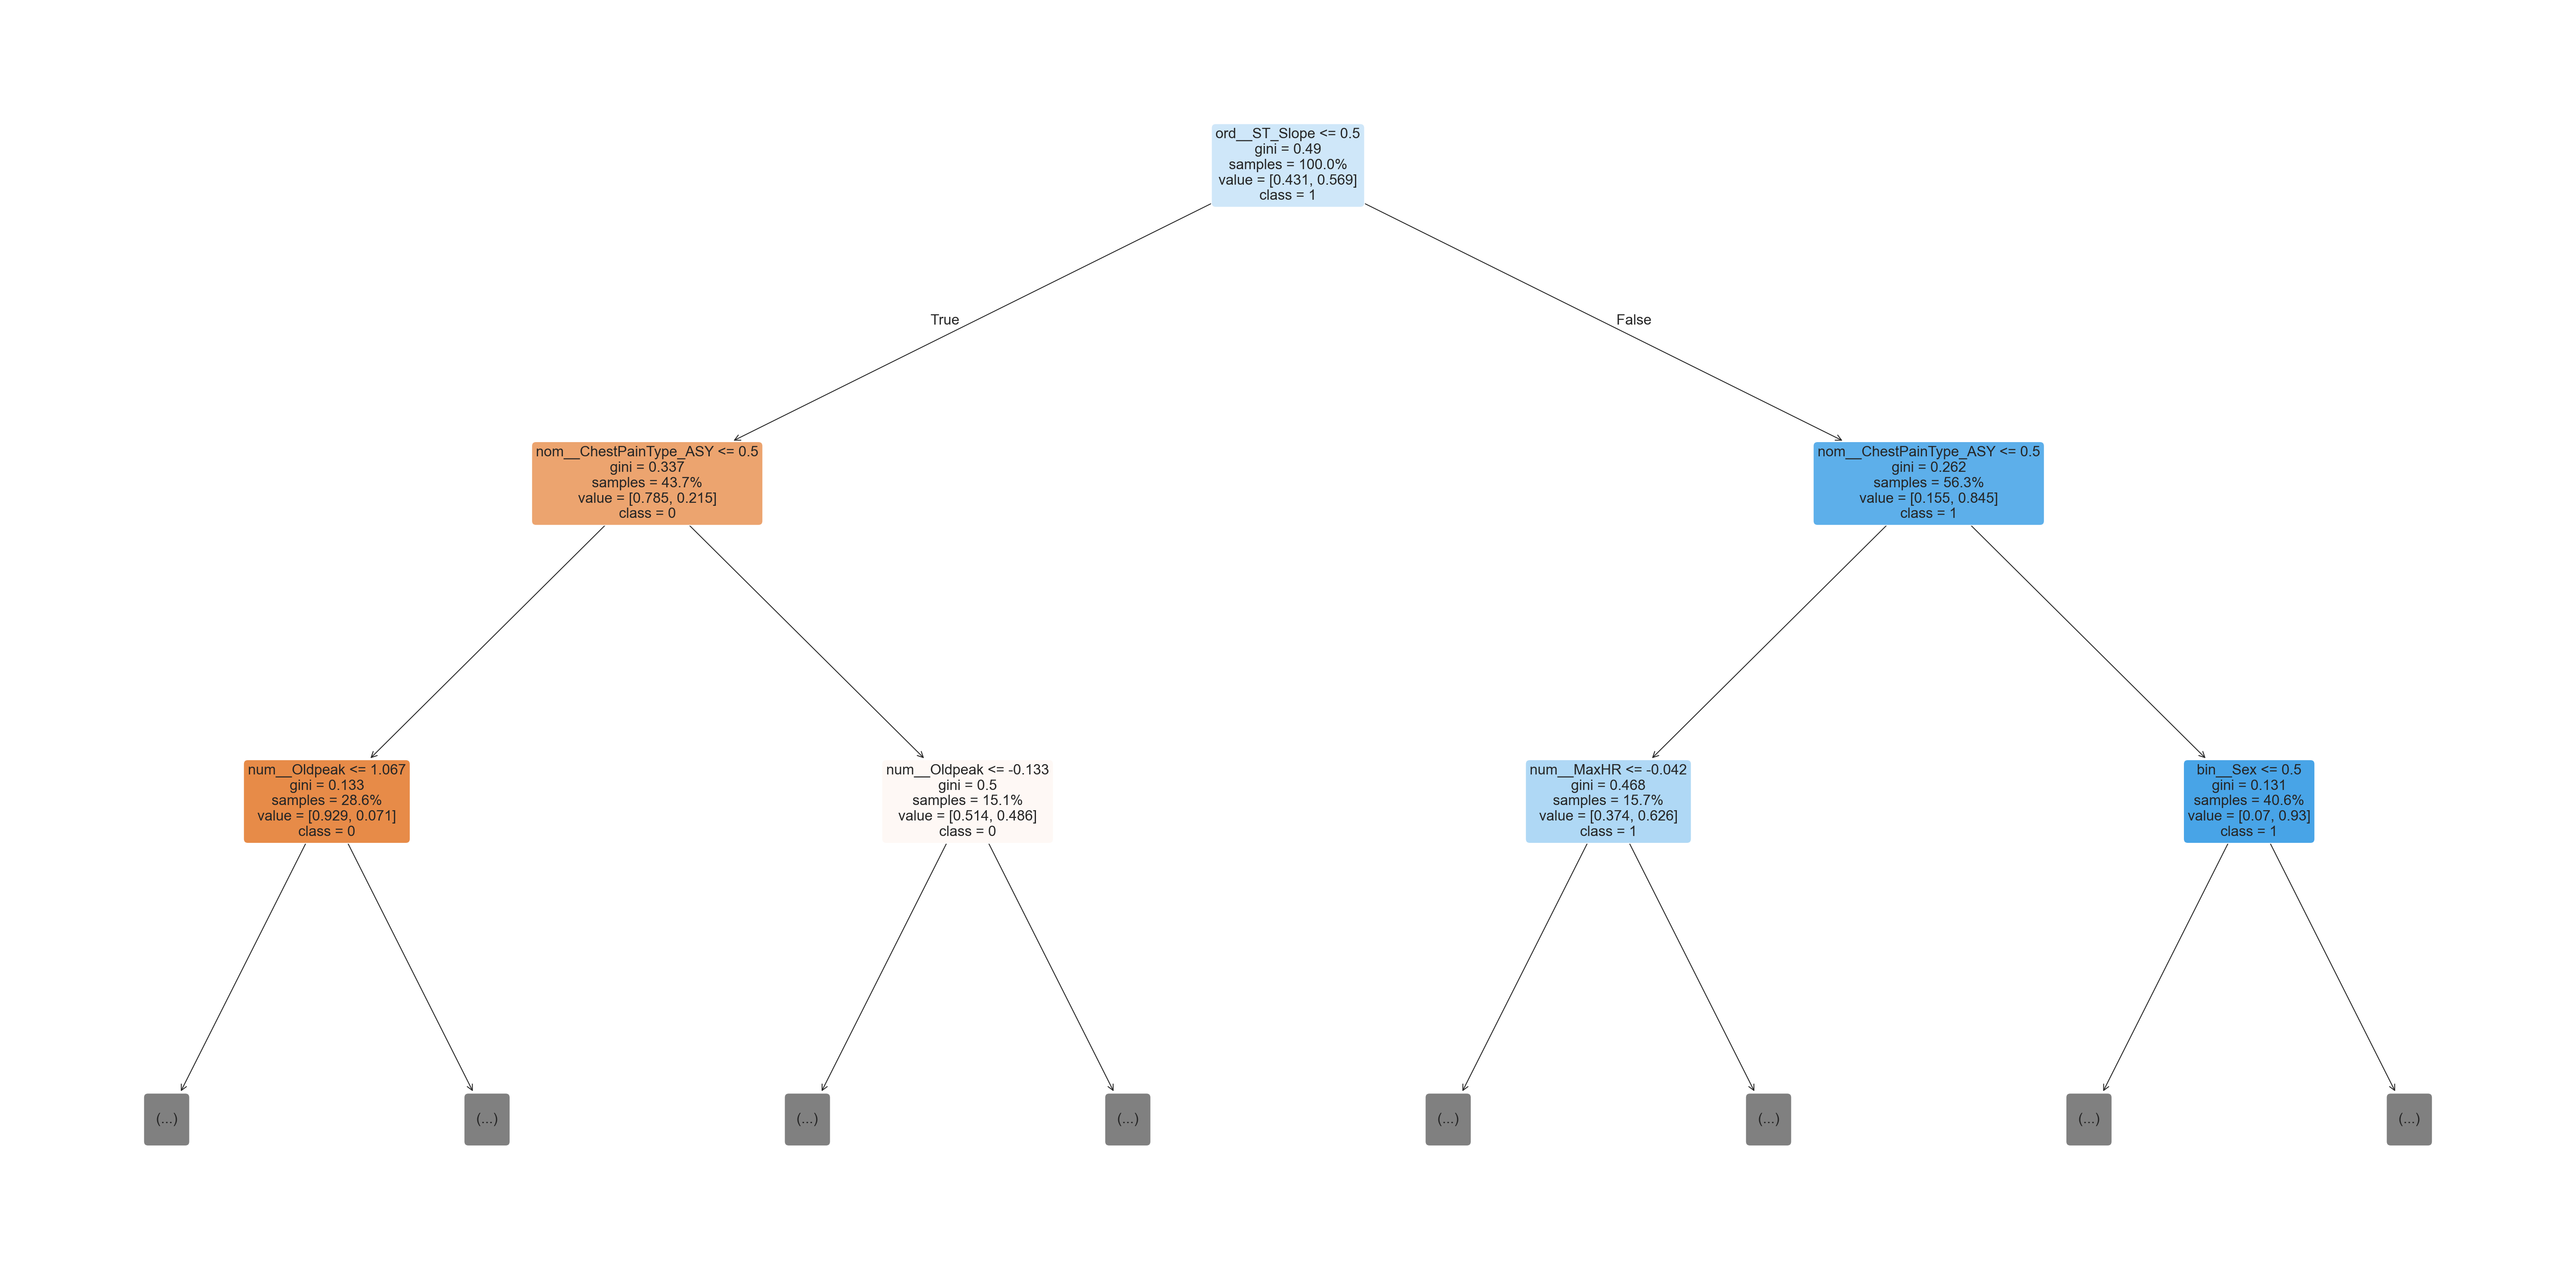

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out(X.columns)

plt.figure(figsize=(40, 20), dpi=150)  # aumenta bastante o tamanho
plot_tree(
    grid_search.best_estimator_.named_steps['DT'],
    feature_names=feature_names,
    class_names=['0', '1'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=16,
    max_depth=2  # Limita a profundidade para evitar sobreposição
)
plt.tight_layout()
plt.show()